In [2]:
# IMPORT FUNCTIONS
from important_functions import run_model, get_ind, get_ind_data, rrc_search, get_last_ap 
import matplotlib.pyplot as plt
import myokit 
import numpy as np
import pickle

def plot_rrc(cycle, p, m_1, m_2, s, l):
    if m_2 == 0:
        fig, axs = plt.subplots(1, figsize = (6, 5), constrained_layout = True)
        endo_dat, endo_IC = run_model([get_ind()], 1, stim = s, start = 0, length = l, cl = cycle, prepace = 600, I0 = 0, path = p, model = m_1)
        endo_result = rrc_search([get_ind()], endo_IC, stim = s, start = 0.1, length = l, cl = cycle, path = p, model = m_1)
        axs.plot(endo_dat['engine.time'], endo_dat['membrane.v'])
        axs.set_title('ENDOCARDIAL | RRC = ' + str(endo_result['RRC']))
    
    else:
        fig, axs = plt.subplots(1, 2, figsize = (12, 5), constrained_layout = True)
        endo_dat, endo_IC = run_model([get_ind()], 1, stim = s, start = 0, length = l, cl = cycle, prepace = 600, I0 = 0, path = p, model = m_1)
        endo_result = rrc_search([get_ind()], endo_IC, stim = s, start = 0.1, length = l, cl = cycle, path = p, model = m_1)
        axs[0].plot(endo_dat['engine.time'], endo_dat['membrane.v'])
        axs[0].set_title('ENDOCARDIAL | RRC = ' + str(endo_result['RRC']))

        epi_dat, epi_IC = run_model([get_ind()], 1, stim = s, start = 0, length = l, cl = cycle, prepace = 600, I0 = 0, path = p, model = m_2)
        epi_result = rrc_search([get_ind()], epi_IC, stim = s, start = 0.1, length = l, cl = cycle, path = p, model = m_2)
        axs[1].plot(epi_dat['engine.time'], epi_dat['membrane.v'])
        axs[1].set_title('EPICARDIAL | RRC = ' + str(epi_result['RRC']))

def calc_rrc(cycle, p, m, s, l, min_dt = None, max_dt = None, prepace = 600):
    dat, IC = run_model([get_ind()], 1, stim = s, start = 0, length = l, cl = cycle, prepace = prepace, I0 = 0, path = p, model = m, min_dt = min_dt, max_dt = max_dt)
    result = rrc_search([get_ind()], IC, stim = s, start = 0.1, length = l, cl = cycle, path = p, model = m, min_dt = min_dt, max_dt = max_dt)
    return(dat, result)

def run_rrc_protocol(cl, p, m, s, l, rrc_stims, min_dt = None, max_dt = None, prepace = 1):


    mod, proto = get_ind_data([get_ind()], p, m) 
    proto.schedule(s, 0, l, cl, 0)

    for ap in list(range(0, len(rrc_stims))):
        proto.schedule(rrc_stims[ap], (((3*ap)+3)*cl)+(int(l)+4), cl-(l+4), cl, 1)

    sim = myokit.Simulation(mod, proto)
    sim.set_min_step_size(dtmin=min_dt)
    sim.set_max_step_size(dtmax=max_dt)
    sim.pre(cl * prepace) 
    dat = sim.run((((3*len(rrc_stims))+3)*cl))

    return(dat)

def get_bench_data(filename):
    data = np.loadtxt(filename)

    t_data = []
    v_data = []
    i_ion = []
    for i in list(range(0, len(data))):
        t_data.append(data[i][0])
        v_data.append(data[i][1])
        i_ion.append(data[i][2])
        
    return(t_data, v_data, i_ion)

# Calculate RRC with isolated simulus injections
def calc_rrc_isolated(cycle, p, m_1, s, l, stims):
    ohara_isolated_t = []
    ohara_isolated_v = []
    for i in list(range(0, len(stims))):
        mod, proto = get_ind_data([get_ind()], p, m_1)
        proto.schedule(s, 0, l, cycle, 0) 
        proto.schedule(stims[i], (cycle*3)+5, 993, cycle, 1)
        sim = myokit.Simulation(mod,proto)
        dat = sim.run(cycle*6) 
        ohara_isolated_t.append(dat['engine.time'])
        ohara_isolated_v.append(dat['membrane.v'])
    return(ohara_isolated_t, ohara_isolated_v)

# Myokit vs openCARP - troubleshooting a discrepency between Grandi RRC values
Guar Calculations:
<div>
<img src="./data/Guar_RRC.jpg" width="500"/>
</div>

My calculations:

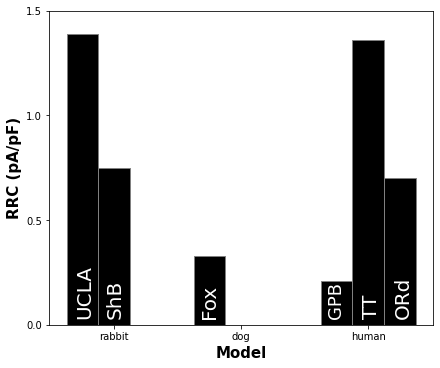

In [28]:

import numpy as np
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, figsize = (6, 5), constrained_layout = True)
 
# set width of bar
barWidth = 0.25
# set height of bar
data_1 = [1.39, 0.33, 0.21] # UCLA, Fox, Grandi
data_2 = [0.75, 0, 1.36]    # ShB, nothing, TT04
data_3 = [0, 0, 0.7]       # nothing, nothing, ORd
 
# Set position of bar on X axis
br1 = np.arange(len(data_1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, data_1, color ='k', width = barWidth, edgecolor ='grey', label ='IT')
plt.bar(br2, data_2, color ='k', width = barWidth, edgecolor ='grey', label ='ECE')
plt.bar(br3, data_3, color ='k', width = barWidth, edgecolor ='grey', label ='CSE')
 
# Adding Xticks
plt.xlabel('Model', fontweight ='bold', fontsize = 15)
plt.ylabel('RRC (pA/pF)', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(data_1))], ['rabbit', 'dog', 'human'])

# set y ticks
listOf_Yticks = np.arange(0, 2, 0.5)
plt.yticks(listOf_Yticks)

# Add text
plt.text(-0.06, 0.05, 'UCLA', rotation = 90, color = 'white', fontsize = 20)
plt.text(0.18, 0.05, 'ShB', rotation = 90, color = 'white', fontsize = 20)
plt.text(0.925, 0.05, 'Fox', rotation = 90, color = 'white', fontsize = 20)
plt.text(1.925, 0.05, 'GPB', rotation = 90, color = 'white', fontsize = 18)
plt.text(2.2, 0.05, 'TT', rotation = 90, color = 'white', fontsize = 20)
plt.text(2.45, 0.05, 'ORd', rotation = 90, color = 'white', fontsize = 20)


plt.show()

## Grandi Model

In order to collect data in bench I first have to log into ubuntu using the command: *wsl -d ubuntu*

Then I will use the following command in the terminal to run the rrc protocol: *bench --imp Grandi --stim-file ./protocols/stims_grandi.dat -Ograndi --dur 18000*

The time-step of integration can be manipulated by using the flag:  *--dt "0.001"*

In [26]:
# COLLECT MYOKIT & BENCH DATA
cycle = 1000
p_grandi = './myokit_models/'
m_1_grandi = 'grandi_flat.mmt' #endocardial model 
m_2_grandi = 'grandi.mmt' #epicardial model 
s_grandi = 9.5
l_grandi = 5
stims_grandi =  [0.25, 0.3, 0.35, 0.4, 0.45]

# AUTOMATIC RRC DETECTION
grandi_dat_endo, result_grandi_endo = calc_rrc(cycle, p_grandi, m_1_grandi, s_grandi, l_grandi)
grandi_dat_epi, result_grandi_epi = calc_rrc(cycle, p_grandi, m_2_grandi, s_grandi, l_grandi)

# MANUAL RRC DETECTION
grandi_dat = run_rrc_protocol(cycle, p_grandi, m_2_grandi, s_grandi, l_grandi, stims_grandi)
grandi_dat_prepaced = run_rrc_protocol(cycle, p_grandi, m_2_grandi, s_grandi, l_grandi, stims_grandi, prepace=600)

# COLLECT OPENCARP DATA 
t_grandi, v_grandi, i_grandi = get_bench_data('./data/grandi_0.0001.txt')
t_grandi_prepace, v_grandi_prepace, i_grandi_prepace = get_bench_data('./data/grandi_prepace.txt')


# COLLECT MYOKIT DT DATA
#grandi_dat = run_rrc_protocol(cycle, p, m_2, s, l, stims, max_dt=1)
#pickle.dump({'t_epi_man': grandi_dat['engine.time'], 'v_epi_man': grandi_dat['membrane.v']}, open('./data/myokit_grandi_dt_data.pkl', 'wb'))


INFO:root:running build_ext
INFO:root:building 'myokit_sim_8_7608703081393935862' extension
INFO:root:creating build
INFO:root:creating build\temp.win-amd64-cpython-39
INFO:root:creating build\temp.win-amd64-cpython-39\Release
INFO:root:creating build\temp.win-amd64-cpython-39\Release\Users
INFO:root:creating build\temp.win-amd64-cpython-39\Release\Users\Kristin
INFO:root:creating build\temp.win-amd64-cpython-39\Release\Users\Kristin\AppData
INFO:root:creating build\temp.win-amd64-cpython-39\Release\Users\Kristin\AppData\Local
INFO:root:creating build\temp.win-amd64-cpython-39\Release\Users\Kristin\AppData\Local\Temp
INFO:root:creating build\temp.win-amd64-cpython-39\Release\Users\Kristin\AppData\Local\Temp\tmpft1qs10zmyokit
INFO:root:"C:\Program Files (x86)\Microsoft Visual Studio\2019\BuildTools\VC\Tools\MSVC\14.29.30133\bin\HostX86\x64\cl.exe" /c /nologo /O2 /W3 /GL /DNDEBUG /MD -IC:\Users\Kristin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\lo

I was thinking that the differences might be due to the time step of integration values between opencarp and myokit. You can see that opencarp uses the same time step throughout the whole simulation while myokits is dynamic. Therefore, I thought that this difference between the two systems (opencarp vs myokit) might cause the discrepency. 

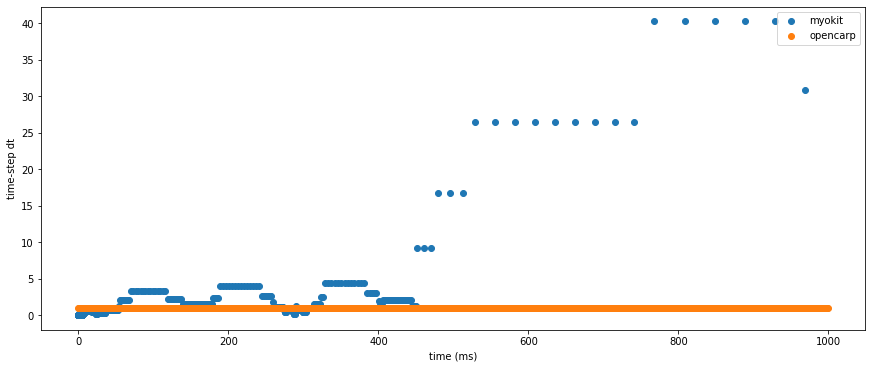

In [3]:
# Analyze time step of integration
t_myokit = grandi_dat_epi['engine.time'].tolist()
myokit_dt = [t_myokit[i+1]-t_myokit[i] for i in list(range(0, len(t_myokit)-1))]

# calculate openCARP time step of integration
opencarp_dt = [t_grandi[i+1]-t_grandi[i] for i in list(range(0, len(t_grandi)-1))]

# plot data
fig, axs = plt.subplots(1, figsize = (12, 5), constrained_layout = True)
axs.scatter(t_myokit[0:len(t_myokit)-1], myokit_dt, label = 'myokit')
axs.scatter(t_grandi[0:1000], opencarp_dt[0:1000], label = 'opencarp')
axs.set_ylabel('time-step dt')
axs.set_xlabel('time (ms)')
axs.legend()

Below you can see the results of running the RRC protocol in bench with different time steps and it doesn't change the RRC.

C:\Users\Kristin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


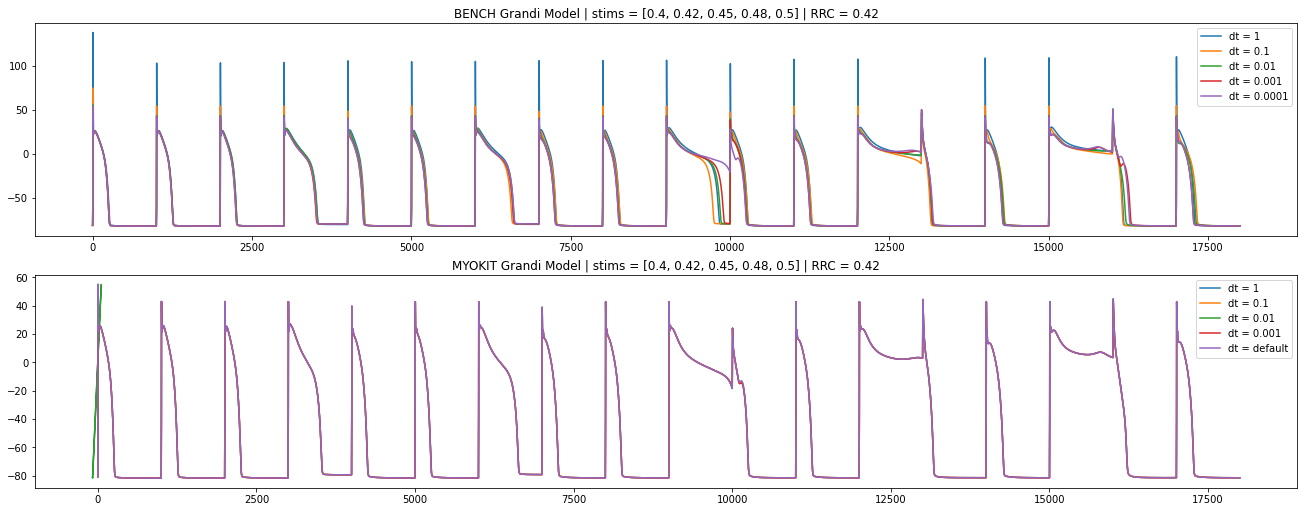

In [60]:
# BENCH DT ANALYSIS 
fig, axs = plt.subplots(2, figsize = (18, 7), constrained_layout = True)

# dt = 1
t_grandi_00, v_grandi_00, i_grandi_00 = get_bench_data('./data/grandi_1.txt')
axs[0].plot(t_grandi_00, v_grandi_00, label = 'dt = 1')

# dt = 0.1
t_grandi_0, v_grandi_0, i_grandi_0 = get_bench_data('./data/grandi_0.1.txt')
axs[0].plot(t_grandi_0, v_grandi_0, label = 'dt = 0.1')

# dt = 0.01
t_grandi_1, v_grandi_1, i_grandi_1 = get_bench_data('./data/grandi_0.01.txt')
axs[0].plot(t_grandi_1, v_grandi_1, label = 'dt = 0.01')

# dt = 0.001
t_grandi_2, v_grandi_2, i_grandi_2 = get_bench_data('./data/grandi_0.001.txt')
axs[0].plot(t_grandi_2, v_grandi_2, label = 'dt = 0.001')

# dt = 0.0001
t_grandi_3, v_grandi_3, i_grandi_3 = get_bench_data('./data/grandi_0.0001.txt')
axs[0].plot(t_grandi_3, v_grandi_3, label = 'dt = 0.0001')

axs[0].set_title('BENCH Grandi Model | stims = '+str(stims_grandi) +' | RRC = 0.42')
axs[0].legend()

# MYOKIT DT ANALYSIS 

# dt = 1
myokit_grandi_data = pickle.load(open('./data/myokit_grandi_dt_data.pkl', 'rb'))
axs[1].plot(myokit_grandi_data['t_epi_man'], myokit_grandi_data['v_epi_man'], label = 'dt = 1')

# dt = 0.1
myokit_grandi_data = pickle.load(open('./data/myokit_grandi_dt1_data.pkl', 'rb'))
axs[1].plot(myokit_grandi_data['t_epi_man'], myokit_grandi_data['v_epi_man'], label = 'dt = 0.1')

# dt = 0.01
myokit_grandi_data = pickle.load(open('./data/myokit_grandi_dt01_data.pkl', 'rb'))
axs[1].plot(myokit_grandi_data['t_epi_man'], myokit_grandi_data['v_epi_man'], label = 'dt = 0.01')

# dt = 0.001
myokit_grandi_data = pickle.load(open('./data/myokit_grandi_dt001_data.pkl', 'rb'))
axs[1].plot(myokit_grandi_data['t_epi_man'], myokit_grandi_data['v_epi_man'], label = 'dt = 0.001')

# dt = default
myokit_grandi_data = pickle.load(open('./data/myokit_grandi_variable_data.pkl', 'rb'))
axs[1].plot(myokit_grandi_data['t_epi_man'], myokit_grandi_data['v_epi_man'], label = 'dt = default')

axs[1].set_title('MYOKIT Grandi Model | stims = '+str(stims_grandi) +' | RRC = 0.42')
axs[1].legend()

To rule out differences in file types causing the RRC discrepency I translated the grandi model from openCARP to mmt. Below you can see that the Grandi model with any potential openCARP changes produces the same RRC as the myokit grandi file. This RRC was calcualted using the binary search automatic detection method. 

In [ ]:
# THIS IS USING THE GRANDI GOOD MODEL FROM OPENCARP
cycle = 1000
p = './myokit_models/'
m_1 = 'Grandigood.mmt' #endocardial model 
m_2 = 0 #epicardial model 
s = 9.5
l = 5

# AUTOMATIC RRC DETECTION
grandigood_dat_endo, result_grandigood_endo = calc_rrc(cycle, p, m_1, s, l)

Text(0.5, 1.0, 'ENDOCARDIAL | RRC = 0.3266')

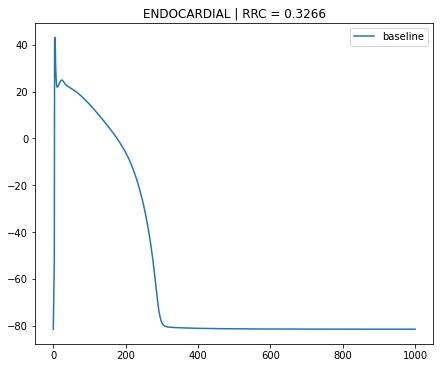

In [55]:
# PLOT GRANDI GOOD DATA
fig, axs = plt.subplots(1, figsize = (6, 5), constrained_layout = True)
axs.plot(grandigood_dat_endo['engine.time'], grandigood_dat_endo['membrane.v'], label = 'baseline')
axs.legend()
axs.set_title('ENDOCARDIAL | RRC = ' + str(result_grandigood_endo['RRC']))


Below you can see that the RRC calulated by the automatic detection is different from the manual detection (using the exact protocol from the paper). Using the manual detection the RRC between openCARP and myokit is only off by less than 0.03 A/F! You could also see that when I prepaced the Grandi model before applying the manual protocol, the RRC appears to be less than 0.4 which is what is calculated using the automatic detection method. Therefore it seems like the problem is that the Guar paper didn't use the Grandi model at steady state!

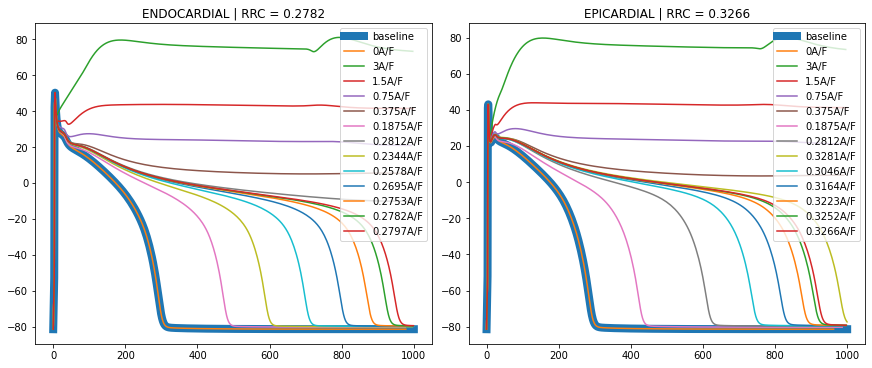

In [6]:
# AUTOMATICALLY CALCULATED RRC - MYOKIT
fig, axs = plt.subplots(1, 2, figsize = (12, 5), constrained_layout = True)
axs[0].plot(grandi_dat_endo['engine.time'], grandi_dat_endo['membrane.v'], label = 'baseline', linewidth=8)
axs[1].plot(grandi_dat_epi['engine.time'], grandi_dat_epi['membrane.v'], label = 'baseline', linewidth=8)
for i in list(range(0, len(result_grandi_epi['data']))):
    axs[0].plot(result_grandi_endo['data'][i]['t_rrc'], result_grandi_endo['data'][i]['v_rrc'], label = str(result_grandi_endo['data'][i]['stim'])+'A/F')
    axs[1].plot(result_grandi_epi['data'][i]['t_rrc'], result_grandi_epi['data'][i]['v_rrc'], label = str(result_grandi_epi['data'][i]['stim'])+'A/F')

axs[0].set_title('ENDOCARDIAL | RRC = ' + str(result_grandi_endo['RRC']))
axs[0].legend()
axs[1].set_title('EPICARDIAL | RRC = ' + str(result_grandi_epi['RRC']))
axs[1].legend()

Text(0, 0.5, 'Membrane Potential (mV)')

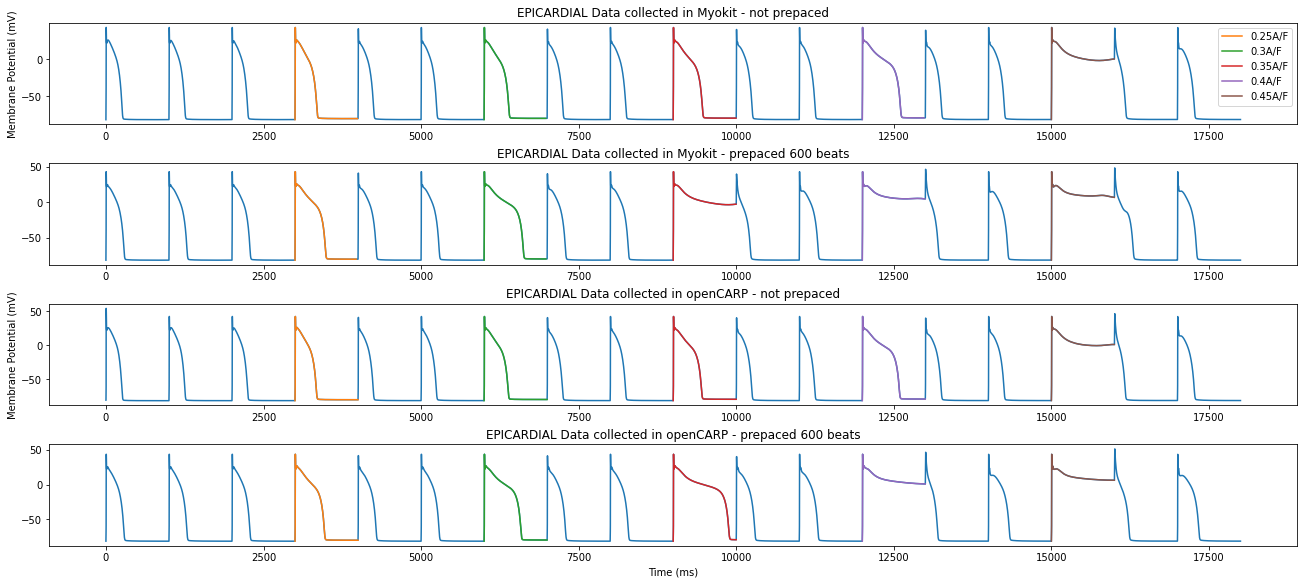

In [27]:
# MANUALLY CALCULATED RRC - MYOKIT
fig, axs = plt.subplots(4, figsize = (18, 8), constrained_layout = True)
axs[0].plot(grandi_dat['engine.time'], grandi_dat['membrane.v'])
axs[1].plot(grandi_dat_prepaced['engine.time'], grandi_dat_prepaced['membrane.v'])
axs[2].plot(t_grandi, v_grandi)
axs[3].plot([t-600000 for t in t_grandi_prepace[600000:len(t_grandi_prepace)]], v_grandi_prepace[600000:len(t_grandi_prepace)])


for i in list(range(0, len(stims_grandi))):
    data_myokit = get_last_ap([grandi_dat['engine.time'], grandi_dat['membrane.v']], (3*i)+3, cl=1000, type = 'not full')
    prepaced_data_myokit = get_last_ap([grandi_dat_prepaced['engine.time'], grandi_dat_prepaced['membrane.v']], (3*i)+3, cl=1000, type = 'not full')
    data_opencarp = get_last_ap([t_grandi, v_grandi], (3*i)+3, cl=1000, type = 'not full')
    prepaced_data_opencarp = get_last_ap([[t-600000 for t in t_grandi_prepace[600000:len(t_grandi_prepace)]], v_grandi_prepace[600000:len(t_grandi_prepace)]], (3*i)+3, cl=1000, type = 'not full')
    axs[0].plot(data_myokit['t'], data_myokit['v'], label = str(stims_grandi[i])+'A/F')
    axs[1].plot(prepaced_data_myokit['t'], prepaced_data_myokit['v'], label = str(stims_grandi[i])+'A/F')
    axs[2].plot(data_opencarp['t'], data_opencarp['v'], label = str(stims_grandi[i])+'A/F')
    axs[3].plot(prepaced_data_opencarp['t'], prepaced_data_opencarp['v'], label = str(stims_grandi[i])+'A/F')

axs[0].legend()
axs[0].set_title('EPICARDIAL Data collected in Myokit - not prepaced')
axs[1].set_title('EPICARDIAL Data collected in Myokit - prepaced 600 beats')
axs[2].set_title('EPICARDIAL Data collected in openCARP - not prepaced')
axs[3].set_title('EPICARDIAL Data collected in openCARP - prepaced 600 beats')
axs[3].set_xlabel('Time (ms)')
axs[0].set_ylabel('Membrane Potential (mV)')
axs[2].set_ylabel('Membrane Potential (mV)')


Lets see if this happens in the OHara model...

## O'Hara-Rudy 

The RRC values calculated by the automatic and manual protocols are a lot closer together for the OHara model compared to Grandi. The automatic method calculated RRC to be 0.70 A/F and the manual method calculated RRC to be 0.72 A/F.

In [19]:
# COLLECT MYOKIT & BENCH DATA
cycle = 1000
p_ohara = './myokit_models/'
m_1_ohara = 'ord_endo.mmt' #endocardial model 
m_2_ohara = 'ord_epi.mmt' #epicardial model 
s_ohara = 80
l_ohara = 0.5
stims_ohara = [0.7, 0.71, 0.72, 0.73, 0.74]

# AUTOMATIC RRC DETECTION
#ohara_dat_endo, result_ohara_endo = calc_rrc(cycle, p_ohara, m_1_ohara, s_ohara, l_ohara)
#ohara_dat_epi, result_ohara_epi = calc_rrc(cycle, p_ohara, m_2_ohara, s_ohara, l_ohara)

# MANUAL RRC DETECTION
#ohara_dat = run_rrc_protocol(cycle, p_ohara, m_1_ohara, s_ohara, l_ohara, stims_ohara)
#ohara_dat_prepaced = run_rrc_protocol(cycle, p_ohara, m_1_ohara, s_ohara, l_ohara, stims_ohara, prepace=600)

# COLLECT OPENCARP DATA 
t_ohara, v_ohara, i_ohara = get_bench_data('./data/ohara.txt')
#t_ohara_prepace, v_ohara_prepace, i_ohara_prepace = get_bench_data('./data/ohara_prepace_cl2000.txt')

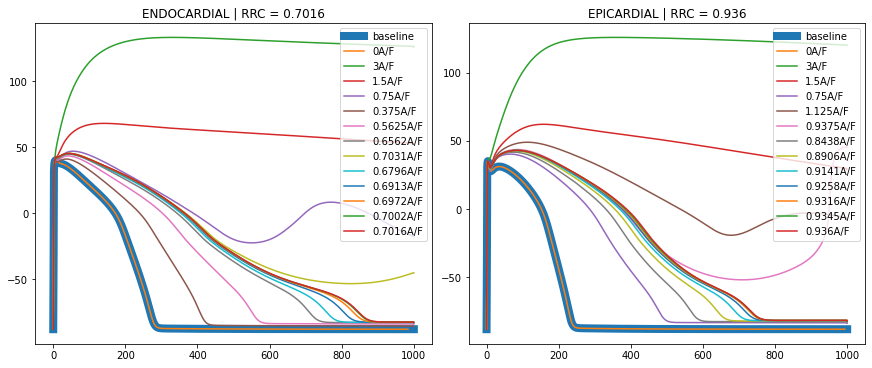

In [48]:
# AUTOMATICALLY CALCULATED RRC - MYOKIT
fig, axs = plt.subplots(1, 2, figsize = (12, 5), constrained_layout = True)
axs[0].plot(ohara_dat_endo['engine.time'], ohara_dat_endo['membrane.v'], label = 'baseline', linewidth=8)
axs[1].plot(ohara_dat_epi['engine.time'], ohara_dat_epi['membrane.v'], label = 'baseline', linewidth=8)
for i in list(range(0, len(result_ohara_epi['data']))):
    axs[0].plot(result_ohara_endo['data'][i]['t_rrc'], result_ohara_endo['data'][i]['v_rrc'], label = str(result_ohara_endo['data'][i]['stim'])+'A/F')
    axs[1].plot(result_ohara_epi['data'][i]['t_rrc'], result_ohara_epi['data'][i]['v_rrc'], label = str(result_ohara_epi['data'][i]['stim'])+'A/F')

axs[0].set_title('ENDOCARDIAL | RRC = ' + str(result_ohara_endo['RRC']))
axs[0].legend()
axs[1].set_title('EPICARDIAL | RRC = ' + str(result_ohara_epi['RRC']))
axs[1].legend()

Text(0, 0.5, 'Membrane Potential (mV)')

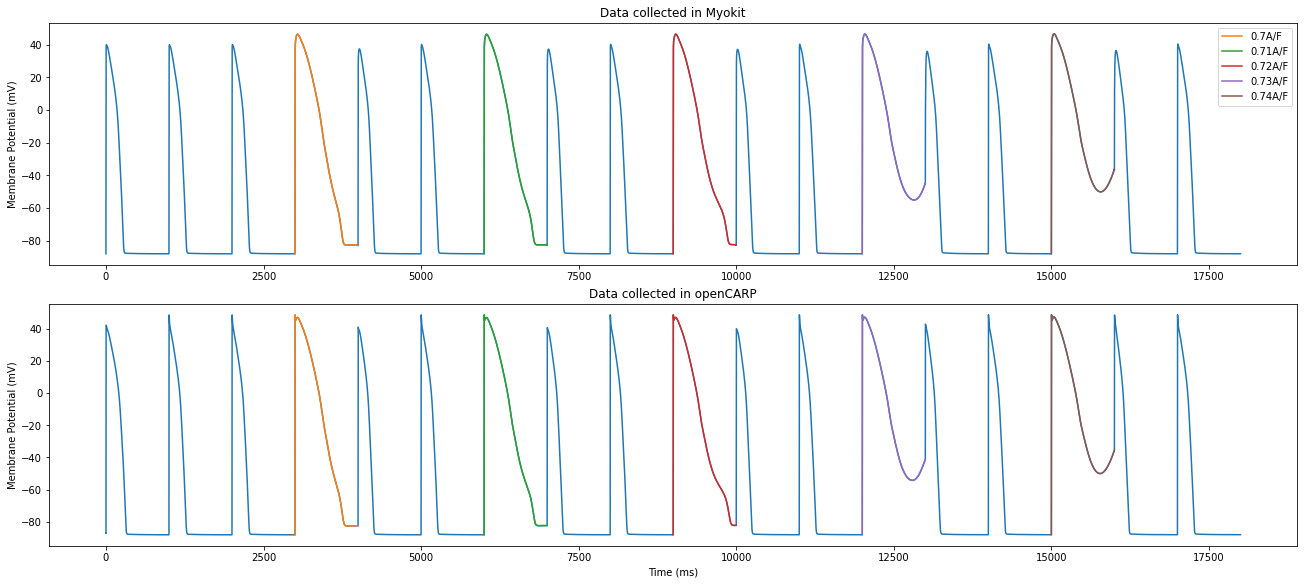

In [20]:
# MANUALLY CALCULATED RRC - MYOKIT
fig, axs = plt.subplots(2, figsize = (18, 8), constrained_layout = True)
axs[0].plot(ohara_dat['engine.time'], ohara_dat['membrane.v'])
axs[1].plot(t_ohara, v_ohara)

for i in list(range(0, len(stims_ohara))):
    data_myokit = get_last_ap([ohara_dat['engine.time'], ohara_dat['membrane.v']], (3*i)+3, cl=cycle, type = 'not full')
    data_opencarp = get_last_ap([t_ohara, v_ohara], (3*i)+3, cl=cycle, type = 'not full')
    axs[0].plot(data_myokit['t'], data_myokit['v'], label = str(stims_ohara[i])+'A/F')
    axs[1].plot(data_opencarp['t'], data_opencarp['v'], label = str(stims_ohara[i])+'A/F')

axs[0].legend()
axs[0].set_title('Data collected in Myokit')
axs[1].set_title('Data collected in openCARP')
axs[1].set_xlabel('Time (ms)')
axs[0].set_ylabel('Membrane Potential (mV)')
axs[1].set_ylabel('Membrane Potential (mV)')

The automatic and manual detection methods will lead to some differences between the protocols aren't exactly the same. For the automatic detection, the stimulus is applied to an action potential state that is freshly prepaced. Conversely, for manual detection, the stimulus is applied to an action potential state that could already have some non-physiologic behvior (by the simulus application that came before it.) Therefore, the manual detection has memory of the other stimuli while the automatic detection does not. This does not seem to make a big difference in the Ohara model but it be causing the large discrepency in the Grandi model. In order to explore this I will inject stimuli in an isolated environment, outside of any protocol to see if there are differences.  

In [ ]:
ohara_isolated_t, ohara_isolated_v = calc_rrc_isolated(1000, p_ohara, m_1_ohara, s_ohara, l_ohara, stims_ohara)

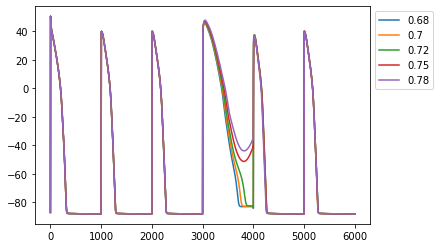

In [15]:
for i in list(range(0, len(ohara_isolated_t))):
    plt.plot(ohara_isolated_t[i], ohara_isolated_v[i], label = str(stims_ohara[i]))
plt.legend(bbox_to_anchor = (1,1))

It looks like we get the same exact results if we calculated RRC with a protocol vs an isolated environment. Lets see if we get the same results in Grandi. 

In [ ]:
grandi_isolated_t, grandi_isolated_v = calc_rrc_isolated(1000, p_grandi, m_2_grandi, s_grandi, l_grandi, stims_grandi)

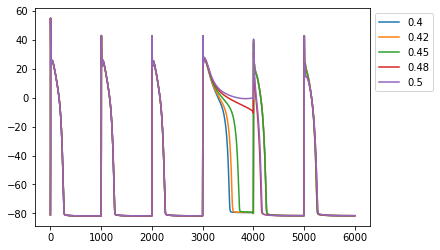

In [17]:
for i in list(range(0, len(grandi_isolated_t))):
    plt.plot(grandi_isolated_t[i], grandi_isolated_v[i], label = str(stims_grandi[i]))
plt.legend(bbox_to_anchor = (1,1))

The isolated protocol also didn't make a difference in Grandi. So it seems like there is something unique to the automatic detection that the Grandi model doesn't like. First, lets make sure that they are both being paced to steady state. The automatic detection paces for 600 beats before injecting stimulus to calculate RRC. Before injecting in a new stimulus it starts from the 600 beat state so it has no memory of other stimuli injections. 

Lets also make sure that the set_state command is working properly. 

In [ ]:
# GRANDI
dat_0, IC_0 = run_model([get_ind()], 1, stim = s_grandi, start = 0, length = l_grandi, cl = 1000, prepace = 3, I0 = 0, path = p_grandi, model = m_2_grandi)
dat_600, IC_600 = run_model([get_ind()], 1, stim = s_grandi, start = 0, length = l_grandi, cl = 1000, prepace = 600, I0 = 0, path = p_grandi, model = m_2_grandi)
dat_1000, IC_1000 = run_model([get_ind()], 1, stim = s_grandi, start = 0, length = l_grandi, cl = 1000, prepace = 1000, I0 = 0, path = p_grandi, model = m_2_grandi)

mod, proto = get_ind_data([get_ind()], p_grandi, m_2_grandi) 
proto.schedule(s_grandi, 0, l_grandi, 1000, 0)
sim = myokit.Simulation(mod, proto)
sim.set_state(IC_600)
dat_state = sim.run(1000)

# OHARA
dato_0, ICo_0 = run_model([get_ind()], 1, stim = s_ohara, start = 0, length = l_ohara, cl = 1000, prepace = 3, I0 = 0, path = p_ohara, model = m_1_ohara)
dato_600, ICo_600 = run_model([get_ind()], 1, stim = s_ohara, start = 0, length = l_ohara, cl = 1000, prepace = 600, I0 = 0, path = p_ohara, model = m_1_ohara)
dato_1000, ICo_1000 = run_model([get_ind()], 1, stim = s_ohara, start = 0, length = l_ohara, cl = 1000, prepace = 1000, I0 = 0, path = p_ohara, model = m_1_ohara)

mod, proto = get_ind_data([get_ind()], p_ohara, m_1_ohara) 
proto.schedule(s_ohara, 0, l_ohara, 1000, 0)
sim = myokit.Simulation(mod, proto)
sim.set_state(ICo_600)
dato_state = sim.run(1000)

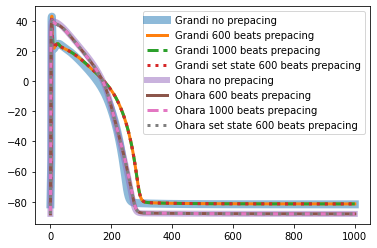

In [32]:
plt.plot(dat_0['engine.time'], dat_0['membrane.v'], linewidth=8, alpha = 0.5, label = 'Grandi no prepacing')
plt.plot(dat_600['engine.time'], dat_600['membrane.v'], linewidth=3, label = 'Grandi 600 beats prepacing')
plt.plot(dat_1000['engine.time'], dat_1000['membrane.v'], linewidth=3, linestyle = 'dashed', label = 'Grandi 1000 beats prepacing')
plt.plot(dat_state['engine.time'], dat_state['membrane.v'], linewidth=3, linestyle = 'dotted', label = 'Grandi set state 600 beats prepacing')

plt.plot(dato_0['engine.time'], dato_0['membrane.v'], linewidth=6, alpha = 0.5, label = 'Ohara no prepacing')
plt.plot(dato_600['engine.time'], dato_600['membrane.v'], linewidth=3, label = 'Ohara 600 beats prepacing')
plt.plot(dato_1000['engine.time'], dato_1000['membrane.v'], linewidth=3, linestyle = 'dashed', label = 'Ohara 1000 beats prepacing')
plt.plot(dato_state['engine.time'], dato_state['membrane.v'], linewidth=3, linestyle = 'dotted', label = 'Ohara set state 600 beats prepacing')

plt.legend(bbox_to_anchor=(1,1))

It seems like the set_state function is working properly becuase the 600 beat prepacing trace (orange-grandi, brown-ohara) and the set state 600 beat prepacing trace (red-grandi, grey-ohara) overlap for both models. However, there is a difference between these two models. It looks like the baseline OHara model is at steady state while the Grandi model is not. I think this could be causing the descrepency between the Grandi RRC values I calculate vs. those from Guar et al. 

Just to be 100% sure... lets see if we come to the same conclusion with the Shannon Model.

## Shannon-Bers (SHB)


In [14]:
cycle = 1000
p_shannon = './myokit_models/'
m_1_shannon = 'SHB_a.mmt' # I am not sure if this is the endocardioal or epicardial version
s_shannon = 9.5
l_shannon = 5
stims_shannon = [0.7, 0.73, 0.75, 0.78, 0.8]

# AUTOMATIC RRC DETECTION
shannon_dat_endo, result_shannon_endo = calc_rrc(cycle, p_shannon, m_1_shannon, s_shannon, l_shannon)

# MANUAL RRC DETECTION
shannon_dat = run_rrc_protocol(cycle, p_shannon, m_1_shannon, s_shannon, l_shannon, stims_shannon)
shannon_dat_prepaced = run_rrc_protocol(cycle, p_shannon, m_1_shannon, s_shannon, l_shannon, stims_shannon, prepace=600)

# COLLECT OPENCARP DATA 
t_shannon, v_shannon, i_shannon = get_bench_data('./data/shannon.txt')
t_shannon_dt, v_shannon_dt, i_shannon_dt = get_bench_data('./data/shannon_0.0001.txt')
t_shannon_prepace, v_shannon_prepace, i_shannon_prepace = get_bench_data('./data/shannon_prepace.txt')

INFO:root:running build_ext
INFO:root:building 'myokit_sim_2_9156571654837610442' extension
INFO:root:creating build
INFO:root:creating build\temp.win-amd64-cpython-39
INFO:root:creating build\temp.win-amd64-cpython-39\Release
INFO:root:creating build\temp.win-amd64-cpython-39\Release\Users
INFO:root:creating build\temp.win-amd64-cpython-39\Release\Users\Kristin
INFO:root:creating build\temp.win-amd64-cpython-39\Release\Users\Kristin\AppData
INFO:root:creating build\temp.win-amd64-cpython-39\Release\Users\Kristin\AppData\Local
INFO:root:creating build\temp.win-amd64-cpython-39\Release\Users\Kristin\AppData\Local\Temp
INFO:root:creating build\temp.win-amd64-cpython-39\Release\Users\Kristin\AppData\Local\Temp\tmpd8d9ig6jmyokit
INFO:root:"C:\Program Files (x86)\Microsoft Visual Studio\2019\BuildTools\VC\Tools\MSVC\14.29.30133\bin\HostX86\x64\cl.exe" /c /nologo /O2 /W3 /GL /DNDEBUG /MD -IC:\Users\Kristin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\lo

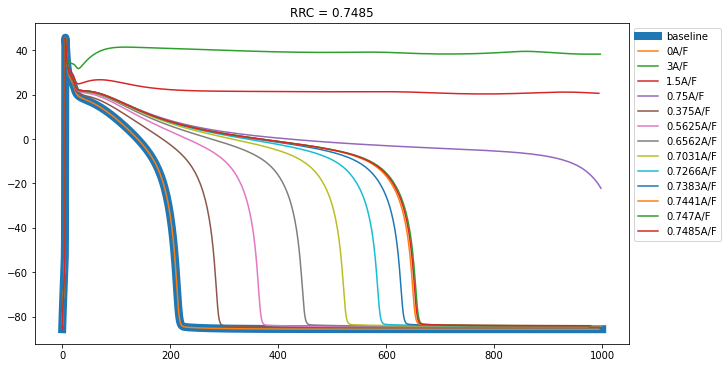

In [15]:
# AUTOMATICALLY CALCULATED RRC - MYOKIT

fig, axs = plt.subplots(1, figsize = (10, 5), constrained_layout = True)
axs.plot(shannon_dat_endo['engine.time'], shannon_dat_endo['membrane.v'], label = 'baseline', linewidth=8)
for i in list(range(0, len(result_shannon_endo['data']))):
    axs.plot(result_shannon_endo['data'][i]['t_rrc'], result_shannon_endo['data'][i]['v_rrc'], label = str(result_shannon_endo['data'][i]['stim'])+'A/F')

axs.set_title('RRC = ' + str(result_shannon_endo['RRC']))
axs.legend(bbox_to_anchor=(1,1))

Text(0, 0.5, 'Membrane Potential (mV)')

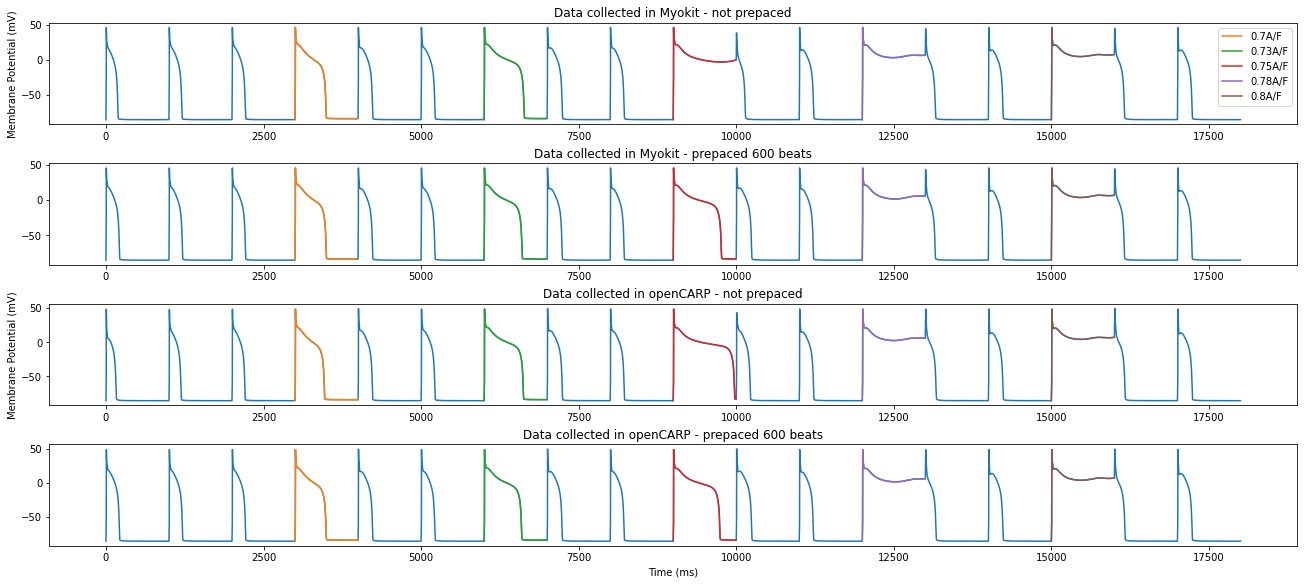

In [25]:
# MANUALLY CALCULATED RRC - MYOKIT
fig, axs = plt.subplots(4, figsize = (18, 8), constrained_layout = True)
axs[0].plot(shannon_dat['engine.time'], shannon_dat['membrane.v'])
axs[1].plot(shannon_dat_prepaced['engine.time'], shannon_dat_prepaced['membrane.v'])
#axs[2].plot(t_shannon_dt, v_shannon_dt, label='dt=0.0001')
axs[2].plot(t_shannon, v_shannon)
axs[3].plot([t-600000 for t in t_shannon_prepace[600000:len(t_shannon_prepace)]], v_shannon_prepace[600000:len(t_shannon_prepace)])


for i in list(range(0, len(stims_shannon))):
    data_myokit = get_last_ap([shannon_dat['engine.time'], shannon_dat['membrane.v']], (3*i)+3, cl=cycle, type = 'not full')
    prepaced_data_myokit = get_last_ap([shannon_dat_prepaced['engine.time'], shannon_dat_prepaced['membrane.v']], (3*i)+3, cl=cycle, type = 'not full')
    data_opencarp = get_last_ap([t_shannon, v_shannon], (3*i)+3, cl=cycle, type = 'not full')
    prepaced_data_opencarp = get_last_ap([[t-600000 for t in t_shannon_prepace[600000:len(t_shannon_prepace)]], v_shannon_prepace[600000:len(t_shannon_prepace)]], (3*i)+3, cl=cycle, type = 'not full')
    axs[0].plot(data_myokit['t'], data_myokit['v'], label = str(stims_shannon[i])+'A/F')
    axs[1].plot(prepaced_data_myokit['t'], prepaced_data_myokit['v'], label = str(stims_shannon[i])+'A/F')
    axs[2].plot(data_opencarp['t'], data_opencarp['v'], label = str(stims_shannon[i])+'A/F')
    axs[3].plot(prepaced_data_opencarp['t'], prepaced_data_opencarp['v'], label = str(stims_shannon[i])+'A/F')

axs[0].legend()
axs[0].set_title('Data collected in Myokit - not prepaced')
axs[1].set_title('Data collected in Myokit - prepaced 600 beats')
axs[2].set_title('Data collected in openCARP - not prepaced')
axs[3].set_title('Data collected in openCARP - prepaced 600 beats')
axs[3].set_xlabel('Time (ms)')
axs[0].set_ylabel('Membrane Potential (mV)')
axs[2].set_ylabel('Membrane Potential (mV)')

In [ ]:
# SHANNON STEADY STATE
dat_0, IC_0 = run_model([get_ind()], 1, stim = s_shannon, start = 0, length = l_shannon, cl = 1000, prepace = 3, I0 = 0, path = p_shannon, model = m_2_grandi)
dat_100, IC_100 = run_model([get_ind()], 1, stim = s_shannon, start = 0, length = l_shannon, cl = 1000, prepace = 100, I0 = 0, path = p_shannon, model = m_1_shannon)
dat_600, IC_600 = run_model([get_ind()], 1, stim = s_shannon, start = 0, length = l_shannon, cl = 1000, prepace = 600, I0 = 0, path = p_shannon, model = m_1_shannon)
dat_1000, IC_1000 = run_model([get_ind()], 1, stim = s_shannon, start = 0, length = l_shannon, cl = 1000, prepace = 1000, I0 = 0, path = p_shannon, model = m_1_shannon)

mod, proto = get_ind_data([get_ind()], p_shannon, m_1_shannon) 
proto.schedule(s_shannon, 0, l_shannon, 1000, 0)
sim = myokit.Simulation(mod, proto)
sim.set_state(IC_600)
dat_state = sim.run(1000)

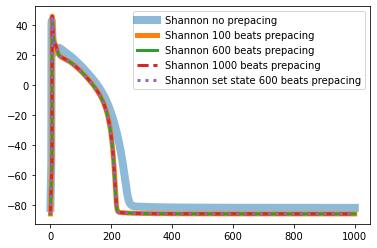

In [83]:
plt.plot(dat_0['engine.time'], dat_0['membrane.v'], linewidth=8, alpha = 0.5, label = 'Shannon no prepacing')
plt.plot(dat_100['engine.time'], dat_100['membrane.v'], linewidth=5, label = 'Shannon 100 beats prepacing')
plt.plot(dat_600['engine.time'], dat_600['membrane.v'], linewidth=3, label = 'Shannon 600 beats prepacing')
plt.plot(dat_1000['engine.time'], dat_1000['membrane.v'], linewidth=3, linestyle = 'dashed', label = 'Shannon 1000 beats prepacing')
plt.plot(dat_state['engine.time'], dat_state['membrane.v'], linewidth=3, linestyle = 'dotted', label = 'Shannon set state 600 beats prepacing')


plt.legend(bbox_to_anchor=(1,1))

When using a cl of 500 I get a much higher RRC value that is closer to the value Guar et al reports (~0.1 A/F). Using a different time step also generates small differences in RRC values. I did not show this clearly for the shannon model but wanted to leave the note here in case it is helpful in the future. 

## ToRORd


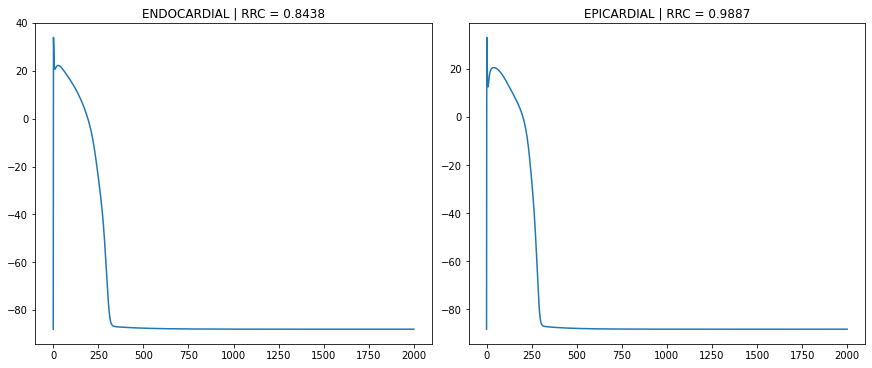

In [93]:
cycle = 2000
p = './tor_ord/'
m_1 = 'tor_ord_endo2.mmt' #endocardial model 
m_2 = 'tor_ord_epi.mmt' #epicardial model 
s = 53
l = 1

plot_rrc(cycle, p, m_1, m_2, s, l)

## Fox - Gilmour (FOX)

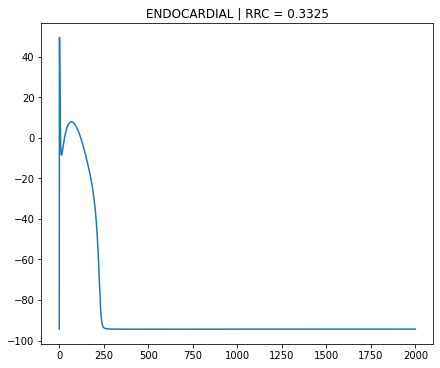

In [94]:
cycle = 2000
p = './more_models/fox/'
m_1 = 'fox.mmt' #endocardial model 
m_2 = 0 #epicardial model 
s = 80
l = 1

plot_rrc(cycle, p, m_1, m_2, s, l)

## Ten Tussure (TT04)

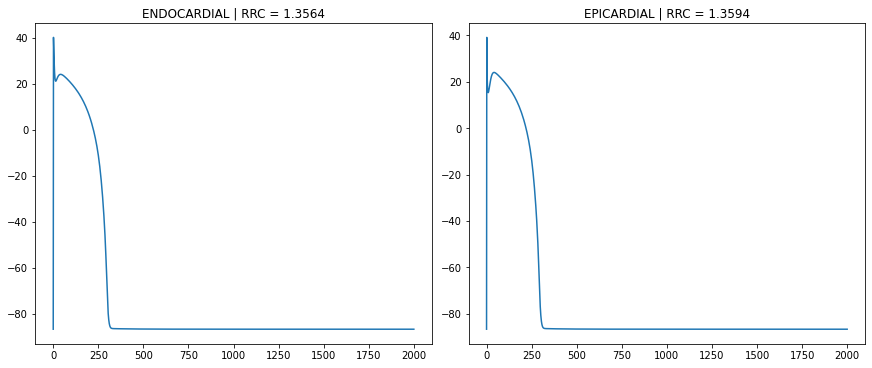

In [95]:
cycle = 2000
p = './more_models/TT/'
m_1 = 'TT_c.mmt' #endocardial
m_2 = 'TT_b.mmt' #epicardial
s = 53
l = 1

plot_rrc(cycle, p, m_1, m_2, s, l)

## UCLA-RAB 

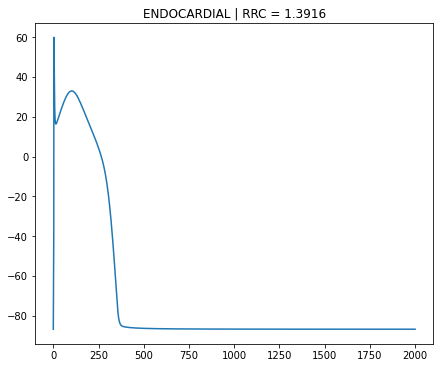

In [96]:
cycle = 2000
p = './more_models/UCLA-RAB/'
m_1 = 'UCLA-RAB.mmt' #endocardial
m_2 = 0 #epicardial
s = 15
l = 3

plot_rrc(cycle, p, m_1, m_2, s, l)

# EXTRA CODE

In [ ]:
endo_dat, endo_IC = run_model([get_ind()], 5, stim = s, start = 0, length = l, cl = cycle, prepace = 600, I0 = 0, path = p, model = m_1)
endo_result = rrc_search([get_ind()], endo_IC, stim = s, start = 0.1, length = l, cl = cycle, path = p, model = m_1)
plt.plot(endo_dat['engine.time'], endo_dat['membrane.v'])
plt.title('ENDOCARDIAL | RRC = ' + str(endo_result['RRC']))

In [ ]:
from tor_ord.important_functions import get_ind, get_ind_data
import myokit
mod, proto = get_ind_data([get_ind()], p, model = m_1)
proto.schedule(s, 0, l, cycle, 0) 
proto.schedule(0.33, 2009, 400, 500, 1)
sim = myokit.Simulation(mod,proto)
dat = sim.run(5000) 
plt.plot(dat['engine.time'], dat['membrane.v'])

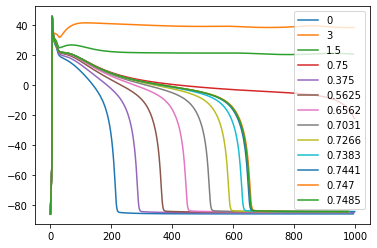

In [7]:
for i in list(range(0, len(endo_result['data']))):
    plt.plot(endo_result['data'][i]['t_rrc'], endo_result['data'][i]['v_rrc'], label = endo_result['data'][i]['stim'])

plt.legend()